In [1]:
from __future__ import print_function
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import time
import cv2
import numpy as np
import tensorflow as tf
import skimage.transform
from src.model import Model
from src.data_loader import dataLoader
import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Plot properties

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 12.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

### Variables

In [3]:
# Change if needed
print_every      = 1000
batch_size       = 1
max_steps        = 8
lstm_hidden      = 128
#n_iters         = 400 # Test on small subset
pretrained_model = './model/lstm1/model-205'

### Load dataset

In [4]:
# Load train dataset
data = dataLoader(directory='./dataset/captcha', dataset_dir='test',\
                  dataset_name='test.txt', max_steps=6, image_width=200,\
                  image_height=64, grd_attn=False, mode='test')

All data Loaded!


In [5]:
n_iters = data.max_length # Test on all data

In [6]:
print(n_iters)

15000


In [7]:
data.all_data[0]

['55000.png',
 ['V', 10, 10, 49, 54],
 ['H', 59, 10, 43, 54],
 ['u', 102, 10, 37, 41],
 ['o', 139, 10, 40, 44],
 ['J', 179, 10, 45, 55],
 ['J', 224, 10, 47, 55]]

### ----------------------------------- Functions -----------------------------------

In [8]:
def bbox_threshold(left, top, width, height):
    valid_box = False
    # If the threshold box is less than 30
    if width * height < 30:
        valid_box = False
    elif left == 0 and top == 0 and\
         width == 0 and height == 0:
        valid_box = False
    else:
        valid_box = True

    return valid_box

In [9]:
def bb_intersection_over_union(boxA, boxB):
    """
    Args:
        bboxes1: shape (total_bboxes1, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (total_bboxes2, 4)
            with x1, y1, x2, y2 point order.

        p1 *-----
           |     |
           |_____* p2

    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return iou

### ----------------------------------- Digit Detection -----------------------------------

In [10]:
# Load Model
model = Model(dim_feature=[672, 128], dim_hidden=128, n_time_step=8,
              alpha_c=1.0, image_height=64, image_width=200, mode='test')
# Build model for inference
pred_bboxs_, alpha_list_ = model.build_test_model()

CNN build model sucess!


In [11]:
## Run FeedForward

# Collect predictions from runs for viz
vis_images  = []
attn_images = []
pred_bboxes = []
grnd_bboxes = []

# Test Data Loader
test_gen = data.gen_data_batch(batch_size)

# Set GPU options
config = tf.GPUOptions(allow_growth=True)

with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    if pretrained_model is not None:
        print("Start testing with pretrained Model..")
        saver.restore(sess, pretrained_model)
    else:
        print("Start testing with Model with random weights...")

    for i in range(n_iters):
        image_batch, image_batch_norm, grd_bboxes_batch = next(test_gen)
        feed_dict = {model.images: image_batch_norm,
                     model.drop_prob: 1.0}
        prediction_bboxes, prediction_alpha = sess.run([pred_bboxs_, alpha_list_], feed_dict)
        
        vis_images.append(image_batch)
        attn_images.append(prediction_alpha)
        pred_bboxes.append(prediction_bboxes)
        grnd_bboxes.append(grd_bboxes_batch)
        
        if i%print_every == 0:
            print('Inference Completion..{%d/%d}' % (i, n_iters))
    #-----------------------------------------------------
    print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
    print('Completed!')
# Close session
sess.close()

Start testing with pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/lstm1/model-205
Inference Completion..{0/15000}
Inference Completion..{1000/15000}
Inference Completion..{2000/15000}
Inference Completion..{3000/15000}
Inference Completion..{4000/15000}
Inference Completion..{5000/15000}
Inference Completion..{6000/15000}
Inference Completion..{7000/15000}
Inference Completion..{8000/15000}
Inference Completion..{9000/15000}
Inference Completion..{10000/15000}
Inference Completion..{11000/15000}
Inference Completion..{12000/15000}
Inference Completion..{13000/15000}
Inference Completion..{14000/15000}
Inference Completion..{15000/15000}
Completed!


In [12]:
print(len(vis_images))
print(len(attn_images))
print(len(pred_bboxes))
print(len(grnd_bboxes))

15000
15000
15000
15000


In [13]:
print(vis_images[0].shape)

(1, 64, 200, 3)


### Compute sequence IOU accuracy

In [14]:
count = 0.0
final_IOU_score = 0.0

In [15]:
for t in range(n_iters):
    sample_seq = 0.0
    sample_iou = 0.0
    for T in range(1, 7, 1):
        ## Ground
        sample_left_grd  = grnd_bboxes[t][0][T][0]
        sample_top_grd   = grnd_bboxes[t][0][T][1]
        sample_width_grd = grnd_bboxes[t][0][T][2]
        sample_heigt_grd = grnd_bboxes[t][0][T][3]
        
        ## Predicted
        # sample_left  = pred_bboxes[t][T][0][0]
        # sample_top   = pred_bboxes[t][T][0][1]
        # sample_width = pred_bboxes[t][T][0][2]
        # sample_heigt = pred_bboxes[t][T][0][3]

#         # Predicted -- Expand 2px to 4 px
#         sample_left  = int(pred_bboxes[t][T][0][0]) - 2
#         if sample_left < 0:
#             sample_left = 0
#         sample_top   = int(pred_bboxes[t][T][0][1]) - 2
#         if sample_top < 0:
#             sample_top = 0
#         sample_width = int(pred_bboxes[t][T][0][2]) + 3
#         sample_heigt = int(pred_bboxes[t][T][0][3]) + 4

        sample_left  = int(pred_bboxes[t][T][0][0])
        sample_top   = int(pred_bboxes[t][T][0][1]) 
        sample_width = int(pred_bboxes[t][T][0][2])
        sample_heigt = int(pred_bboxes[t][T][0][3])
        
        vld_bbox_prd = bbox_threshold(left=sample_left, top=sample_top,\
                                width=sample_width, height=sample_heigt)

        vld_bbox_grd = bbox_threshold(left=sample_left_grd, top=sample_top_grd,\
                                width=sample_width_grd, height=sample_heigt_grd)
        
        if vld_bbox_grd:
            sample_seq += 1
            if vld_bbox_prd:
                # Predicted
                sample_right = sample_left + sample_width
                sample_down  = sample_top  + sample_heigt
                # Ground truth
                sample_right_grd = sample_left_grd + sample_width_grd
                sample_down_grd  = sample_top_grd  + sample_heigt_grd

                boxA = (sample_left, sample_top, sample_right, sample_down)
                boxB = (sample_left_grd, sample_top_grd, sample_right_grd, sample_down_grd)

                sample_iou += bb_intersection_over_union(boxA, boxB)
    if i%print_every == 0:
        print('Inference Completion..{%d/%d}' % (t, n_iters))
    final_IOU_score += sample_iou/sample_seq
    count += 1.0
#-----------------------------------------------------
print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
print('Completed!')

Inference Completion..{15000/15000}
Completed!


In [16]:
print('Final Sequence IOU score = ', np.ceil((final_IOU_score/count)*100), '%')

Final Sequence IOU score =  89.0 %


### BBox Visualization

In [18]:
shift_viz = 500

In [19]:
attn_images[0][0].shape

(1, 672)

In [20]:
## Upscale attention mask
upscaled_attn_images = []
for k in range(0, n_iters, shift_viz):
    sample_attention_res_interm = []
    for K in range(1, 7, 1):
        sample_attn_reshaped = np.reshape(attn_images[k][K], (14, 48))
        sample_attention_res = skimage.transform.pyramid_expand(sample_attn_reshaped, upscale=4.55, sigma=1, multichannel=False)
        sample_attention_res_interm.append(sample_attention_res)
    
    upscaled_attn_images.append(sample_attention_res_interm)

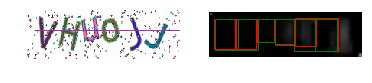

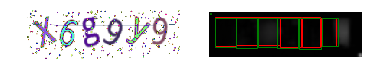

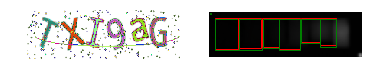

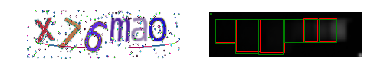

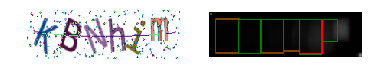

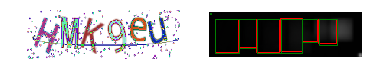

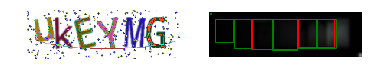

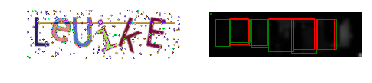

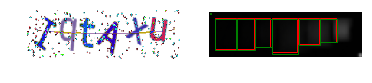

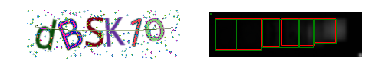

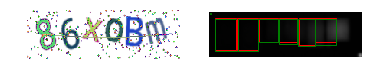

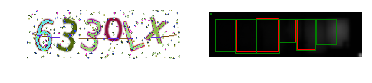

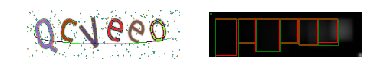

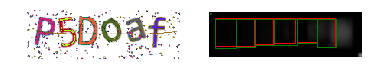

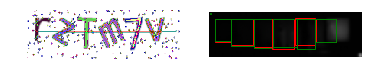

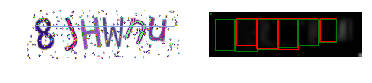

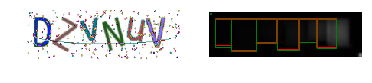

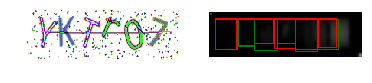

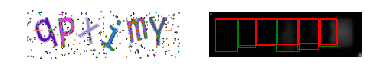

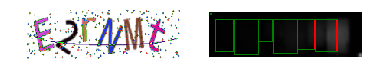

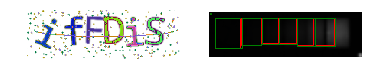

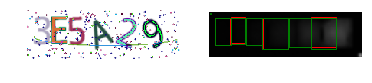

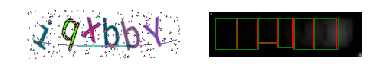

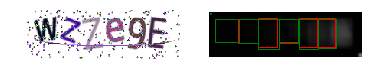

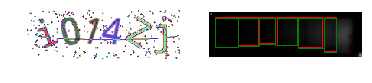

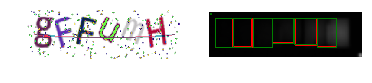

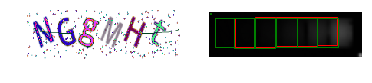

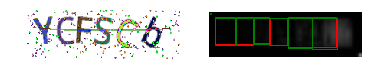

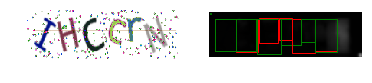

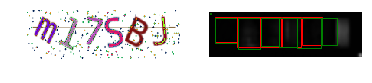

In [24]:
count = 0
for t in range(0, n_iters, shift_viz):
    # Plot original image
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(vis_images[t][0])
    ax[0].axis('off')
    ax[1].imshow(vis_images[t][0])
    for T in range(1, 7, 1):
        # ax[1].imshow(upscaled_attn_images[count][T], alpha=0.5)
        
        # Ground
        sample_left_grd  = grnd_bboxes[t][0][T][0]
        sample_top_grd   = grnd_bboxes[t][0][T][1]
        sample_width_grd = grnd_bboxes[t][0][T][2]
        sample_heigt_grd = grnd_bboxes[t][0][T][3]

        sample_left  = int(pred_bboxes[t][T][0][0])
        sample_top   = int(pred_bboxes[t][T][0][1])
        sample_width = int(pred_bboxes[t][T][0][2])
        sample_heigt = int(pred_bboxes[t][T][0][3])

#         # Predicted -- Expand 2px to 4 px
#         sample_left  = int(pred_bboxes[t][T][0][0]) - 2
#         if sample_left < 0:
#             sample_left = 0
#         sample_top   = int(pred_bboxes[t][T][0][1]) - 2
#         if sample_top < 0:
#             sample_top = 0
#         sample_width = int(pred_bboxes[t][T][0][2]) + 3
#         sample_heigt = int(pred_bboxes[t][T][0][3]) + 4
            
#         vld_bbox = bbox_threshold(left=sample_left, top=sample_top,\
#                           width=sample_width, height=sample_heigt)
        
#         if vld_bbox:
#             # Predicted
#             sample_right = sample_left + sample_width
#             sample_down  = sample_top  + sample_heigt
#             # Ground truth
#             sample_right_grd = sample_left_grd + sample_width_grd
#             sample_down_grd  = sample_top_grd  + sample_heigt_grd

#             boxA = (sample_left, sample_top, sample_right, sample_down)
#             boxB = (sample_left_grd, sample_top_grd, sample_right_grd, sample_down_grd)
                
#             iou_sample = bb_intersection_over_union(boxA, boxB)
#         else:
#             iou_sample = 0.0
                
        rect1 = patches.Rectangle((sample_left, sample_top), sample_width, sample_heigt,linewidth=1,edgecolor='r',facecolor='none')  
        rect2 = patches.Rectangle((sample_left_grd, sample_top_grd), sample_width_grd, sample_heigt_grd,linewidth=1,edgecolor='g',facecolor='none')  
        
        #ax[T+1].text(0, 1, (int(sample_left), int(sample_top), int(sample_width), int(sample_heigt)), color='black', backgroundcolor='white', fontsize=7)
        #ax[T+1].text(0, 56, 'iou: ' + str(np.round(iou_sample, decimals=3)), color='black', backgroundcolor='white', fontsize=7)
        ax[1].add_patch(rect1)
        ax[1].add_patch(rect2)
        ax[1].axis('off')
    
    plt.show()
    count += 1

### ------------------------------ Digit Classification -----------------------------------

In [17]:
# Load classifier dataset
from src.data_loader_seq_classify import dataLoader

In [18]:
data = dataLoader(directory='./dataset', dataset_dir='test_cropped',
                  height=24, width=24, dataset_name='test.txt',
                  max_steps=max_steps, mode='Test')

All data-loaded!


In [19]:
# Test Data Loader
test_loader = data.gen_data_batch(batch_size=batch_size)

In [20]:
sample_ground_labels = []

for i in range(n_iters):
    _, _, _, label_batch = next(test_loader)
    sample_ground_labels.append(label_batch)

In [21]:
viz = True
pretrained_clfy_model='./model/clsfy3/model-385'

In [22]:
plt.rcParams['figure.figsize'] = (3.0, 3.0)  # set default size of plots

In [23]:
#del Clfy_Model # -- Uncomment if re-running without restarting the kernel

In [24]:
from src.baseline_classify import Model as Clfy_Model

In [25]:
# Reset graph
tf.reset_default_graph()
# Load
clfy_model = Clfy_Model(image_height=24, image_width=24, mode='test')
# Predictions
_, predictions  = clfy_model.build_test_model()

Classification build model sucess!


### Compute sequence digit prediction accuracy

In [26]:
sample_ground_labels[t][0]

[2.0, 0.0]

In [27]:
count = 0.0
final_seq_acc_grd = 0.0
final_seq_acc_prd = 0.0

In [28]:
with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    # To load
    saver = tf.train.Saver()
    # Load pretrained model
    if pretrained_clfy_model is not None:
        print("Start testing with Classification pretrained Model..")
        saver.restore(sess, pretrained_clfy_model)
    else:
        print("Start testing with Classification Model with random weights...")
    # Run predictions
    for t in range(n_iters):
        # Get image
        test_image = vis_images[t][0]
        sample_cnt = 0
        sample_seq = len(sample_ground_labels[t][0])
        sample_acc_grd = 0.0
        sample_acc_prd = 0.0
        # Loop through steps
        for T in range(max_steps):
            # Predicted
            # sample_left  = pred_bboxes[t][T][0][0]
            # sample_top   = pred_bboxes[t][T][0][1]
            # sample_width = pred_bboxes[t][T][0][2]
            # sample_heigt = pred_bboxes[t][T][0][3]

            sample_left  = int(pred_bboxes[t][T][0][0]) - 2
            if sample_left < 0:
                sample_left = 0
            sample_top   = int(pred_bboxes[t][T][0][1]) - 2
            if sample_top < 0:
                sample_top = 0
            sample_width = int(pred_bboxes[t][T][0][2]) + 3
            sample_heigt = int(pred_bboxes[t][T][0][3]) + 4
            
            vld_bbox = bbox_threshold(left=sample_left, top=sample_top,\
                                      width=sample_width, height=sample_heigt)
                 
            if vld_bbox:
                pred_extract_img = test_image[sample_top:sample_top+sample_heigt, sample_left:sample_left+sample_width, :]
                pred_extract_img = cv2.resize(pred_extract_img, (24, 24), interpolation = cv2.INTER_LINEAR)
                pred_extract_img_norm = pred_extract_img/127.5 - 1.0
                pred_extract_img_norm = np.expand_dims(pred_extract_img_norm, axis=0) # [1, H, W, C]
            #--------------------------------------------------
            # Ground
            sample_left_grd  = int(grnd_bboxes[t][0][T][0])
            sample_top_grd   = int(grnd_bboxes[t][0][T][1])
            sample_width_grd = int(grnd_bboxes[t][0][T][2])
            sample_heigt_grd = int(grnd_bboxes[t][0][T][3])
            
            vld_grd_bbox = bbox_threshold(left=sample_left_grd, top=sample_top_grd,\
                                      width=sample_width_grd, height=sample_heigt_grd)
            
            # Ground
            if vld_grd_bbox:
                exact_img = test_image[sample_top_grd:sample_top_grd+sample_heigt_grd, sample_left_grd:sample_left_grd+sample_width_grd, :]
                exact_img = cv2.resize(exact_img, (24, 24), interpolation = cv2.INTER_LINEAR)
                exact_img_norm = exact_img/127.5 - 1.0
                exact_img_norm = np.expand_dims(exact_img_norm, axis=0) # [1, H, W, C]
                feed_dict  = {clfy_model.images: exact_img_norm,
                              clfy_model.drop_prob: 1.0}
                pred_exact = sess.run(predictions, feed_dict)
                
                if pred_exact[0] == sample_ground_labels[t][0][sample_cnt] and sample_cnt < sample_seq:
                    sample_acc_grd += 1.0
                
                # Predictions
                if vld_grd_bbox and vld_bbox:
                    feed_dict = {clfy_model.images: pred_extract_img_norm,
                                 clfy_model.drop_prob: 1.0}
                    pred = sess.run(predictions, feed_dict)
                    
                    if pred[0] == sample_ground_labels[t][0][sample_cnt] and sample_cnt < sample_seq:
                        sample_acc_prd += 1.0
                
                # Update
                sample_cnt += 1
                
        final_seq_acc_grd += sample_acc_grd/sample_seq
        final_seq_acc_prd += sample_acc_prd/sample_seq
        
        if t%print_every == 0:
            print('Inference Completion..{%d/%d}' % (t, n_iters))
        count += 1.0
#-----------------------------------------------------
print('Inference Completion..{%d/%d}' % (n_iters, n_iters))
print('Completed!')

Start testing with Classification pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/clsfy3/model-385
Inference Completion..{0/13068}
Inference Completion..{1000/13068}
Inference Completion..{2000/13068}
Inference Completion..{3000/13068}
Inference Completion..{4000/13068}
Inference Completion..{5000/13068}
Inference Completion..{6000/13068}
Inference Completion..{7000/13068}
Inference Completion..{8000/13068}
Inference Completion..{9000/13068}
Inference Completion..{10000/13068}
Inference Completion..{11000/13068}
Inference Completion..{12000/13068}
Inference Completion..{13000/13068}
Inference Completion..{13068/13068}
Completed!


In [29]:
print('Ground  Sequence Classification Accuracy: ', np.round((final_seq_acc_grd/count)*100, 3), '%')
print('Predict Sequence Classification Accuracy: ', np.round((final_seq_acc_prd/count)*100, 3), '%')

Ground  Sequence Classification Accuracy:  94.351 %
Predict Sequence Classification Accuracy:  93.477 %


### Digit Prediction Accuracy

Start testing with Classification pretrained Model..
INFO:tensorflow:Restoring parameters from ./model/clsfy3/model-385


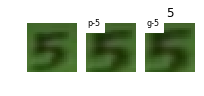

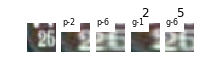

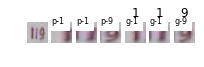

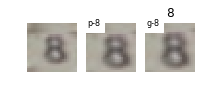

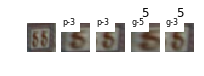

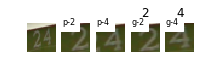

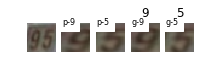

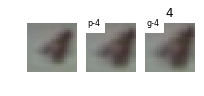

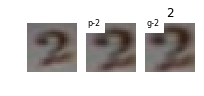

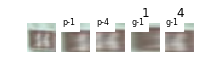

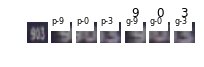

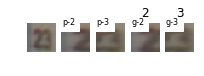

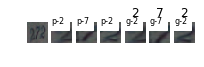

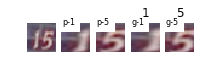

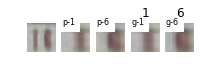

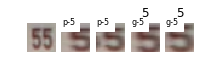

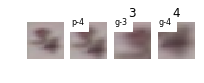

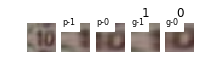

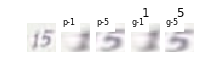

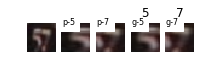

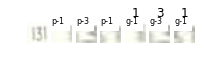

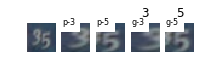

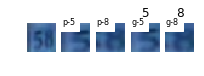

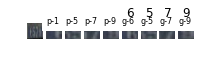

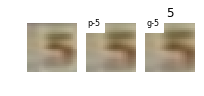

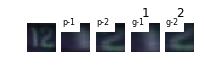

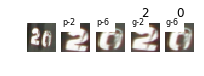

In [30]:
with tf.Session(config=tf.ConfigProto(gpu_options=config)) as sess:
    # Intialize the training graph
    sess.run(tf.global_variables_initializer())
    # To load
    saver = tf.train.Saver()
    # Load pretrained model
    if pretrained_clfy_model is not None:
        print("Start testing with Classification pretrained Model..")
        saver.restore(sess, pretrained_clfy_model)
    else:
        print("Start testing with Classification Model with random weights...")
    # Run predictions
    for t in range(0, n_iters, shift_viz):
        # Get image
        test_image = vis_images[t][0]
        # Valid predictions
        valid_pred     = []
        valid_pred_img = []
        grund_pred     = []
        grund_pred_img = []
        num_valid_pred = 0
        num_valid_grnd_pred = 0
        # Loop through steps
        for T in range(max_steps):
            # Predicted
            # sample_left  = pred_bboxes[t][T][0][0]
            # sample_top   = pred_bboxes[t][T][0][1]
            # sample_width = pred_bboxes[t][T][0][2]
            # sample_heigt = pred_bboxes[t][T][0][3]

            sample_left  = int(pred_bboxes[t][T][0][0]) - 2
            if sample_left < 0:
                sample_left = 0
            sample_top   = int(pred_bboxes[t][T][0][1]) - 2
            if sample_top < 0:
                sample_top = 0
            sample_width = int(pred_bboxes[t][T][0][2]) + 3
            sample_heigt = int(pred_bboxes[t][T][0][3]) + 4
            
            vld_bbox = bbox_threshold(left=sample_left, top=sample_top,\
                                      width=sample_width, height=sample_heigt)
                 
            if vld_bbox:
                extract_img = test_image[sample_top:sample_top+sample_heigt, sample_left:sample_left+sample_width, :]
                extract_img = cv2.resize(extract_img, (24, 24), interpolation = cv2.INTER_LINEAR)
                extract_img_norm = extract_img/127.5 - 1.0
                extract_img_norm = np.expand_dims(extract_img_norm, axis=0) # [1, H, W, C]
                # Predictions
                feed_dict = {clfy_model.images: extract_img_norm,
                             clfy_model.drop_prob: 1.0}
                pred = sess.run(predictions, feed_dict)
                valid_pred.append(pred)
                valid_pred_img.append(extract_img)        
                num_valid_pred += 1
            #--------------------------------------------------
            # Ground
            sample_left_grd  = int(grnd_bboxes[t][0][T][0])
            sample_top_grd   = int(grnd_bboxes[t][0][T][1])
            sample_width_grd = int(grnd_bboxes[t][0][T][2])
            sample_heigt_grd = int(grnd_bboxes[t][0][T][3])
            
            vld_grd_bbox = bbox_threshold(left=sample_left_grd, top=sample_top_grd,\
                                      width=sample_width_grd, height=sample_heigt_grd)
            
            if vld_grd_bbox:
                exact_img = test_image[sample_top_grd:sample_top_grd+sample_heigt_grd, sample_left_grd:sample_left_grd+sample_width_grd, :]
                exact_img = cv2.resize(exact_img, (24, 24), interpolation = cv2.INTER_LINEAR)
                exact_img_norm = exact_img/127.5 - 1.0
                exact_img_norm = np.expand_dims(exact_img_norm, axis=0) # [1, H, W, C]
                # Predictions
                feed_dict  = {clfy_model.images: exact_img_norm,
                              clfy_model.drop_prob: 1.0}
                pred_exact = sess.run(predictions, feed_dict)
                grund_pred.append(pred_exact)
                grund_pred_img.append(exact_img) 
                num_valid_grnd_pred += 1
    
        if viz:
            # Plot original image
            fig,ax = plt.subplots(1, num_valid_pred + num_valid_grnd_pred  + 1)
            test_img = cv2.resize(test_image, (24, 24), interpolation = cv2.INTER_AREA)
            ax[0].imshow(test_img)
            ax[0].axis('off')
            for tT in range(num_valid_pred):
                ax[tT+1].imshow(valid_pred_img[tT])
                ax[tT+1].text(0, 1, 'p-' + str(valid_pred[tT][0]), color='black', backgroundcolor='white', fontsize=8)
                ax[tT+1].axis('off')
            
            count=num_valid_pred+1
            for tT in range(num_valid_grnd_pred):
                # Ground Label
                grd_lbl = int(sample_ground_labels[t][0][tT])
                ax[count].imshow(grund_pred_img[tT])
                ax[count].set_title(str(grd_lbl))
                ax[count].text(0, 1, 'g-' + str(grund_pred[tT][0]), color='black', backgroundcolor='white', fontsize=8)
                ax[count].axis('off')
                count += 1
            plt.show()